### First use the datasets that we will use

In [87]:
#Load the Libraries

import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


### Load and Explore the Data

In [54]:
df = pd.read_csv('glass.csv')
features = df.columns[:-1].tolist()
df.head(10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [19]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

### Summarize the distribution of the numerical variables.

In [20]:
#Descriptive Statistics

df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not on the same scale. For example Si has a mean of 72.65 while Fe has a mean value of 0.057. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly.

In [21]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

The dataset is pretty unbalanced. The instances of types 1 and 2 constitute more than 67 % of the glass types.

## Data Visualization

#### Univariate Plots

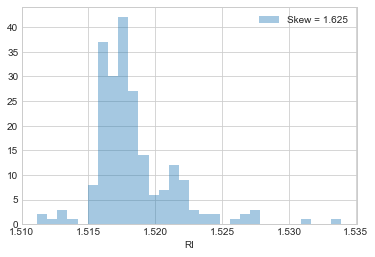

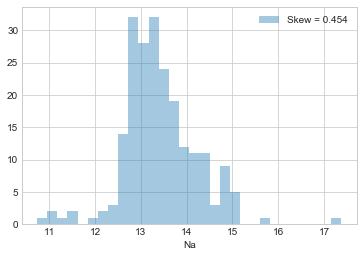

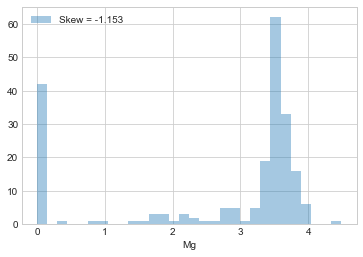

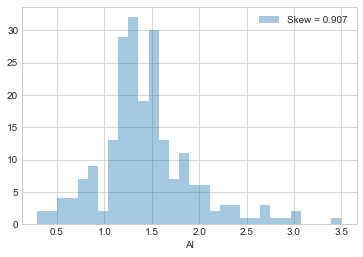

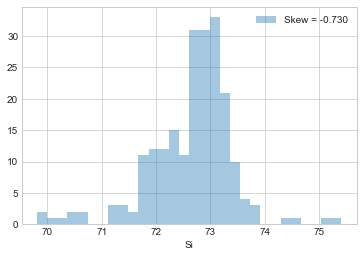

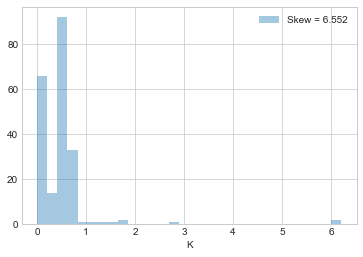

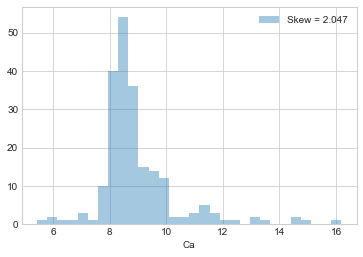

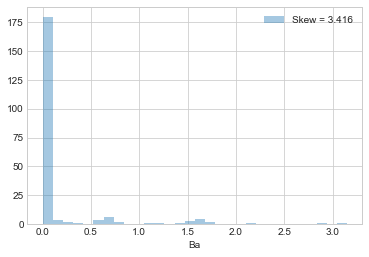

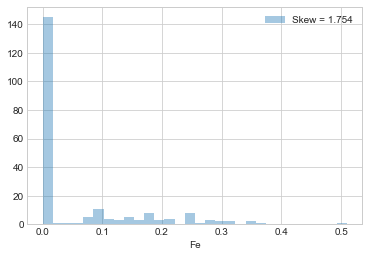

In [89]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers.Let's identify the indices of the observations containing outliers using Box Plot

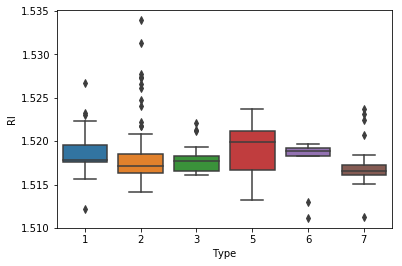

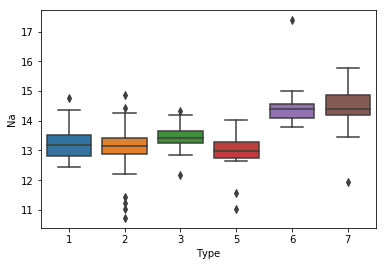

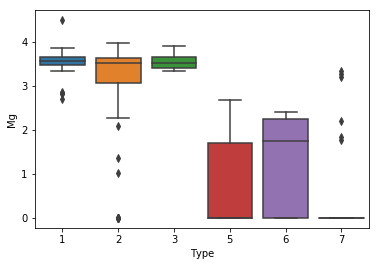

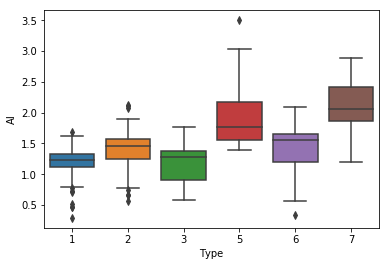

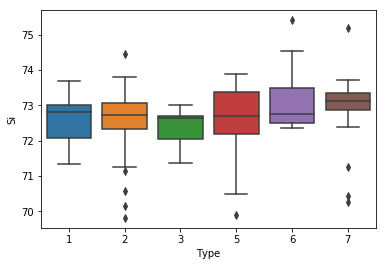

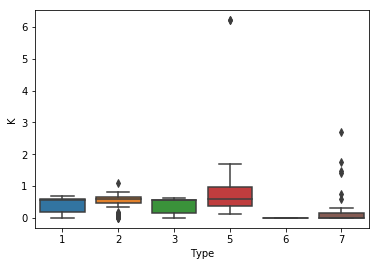

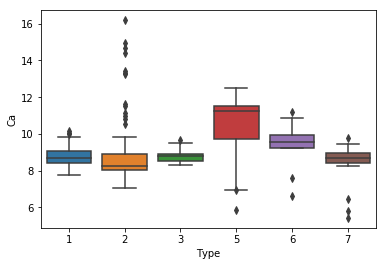

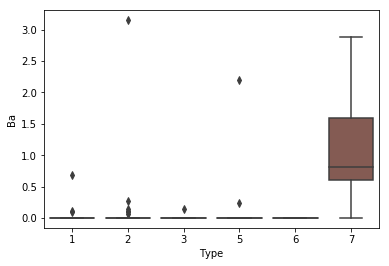

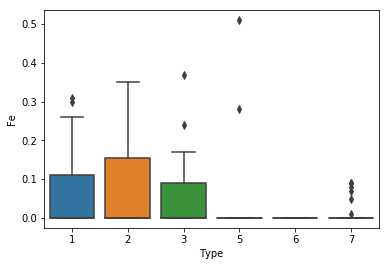

In [56]:
# The formula tells us that any number that outside the range [Q1 - 1.5*IQR, Q2 + 1.5*IQR] will be outliers

# For examples, for Na, 
# IQR = Q3 - Q1 = 13.825000 - 12.907500 = 0.9175
# Q1 - 1.5*IQR = 12.907500 - 1.5*0.9175 = 11.53125 
# Q3 + 1.5*IQR = 13.825000 + 1.5*0.9175 = 15.20125

# Therefore any number that's outside [11.53125, 15.20125] will be an outlier. 
# Since the maximum number for Na is 17.380000, there exists at least one outlier. 

# Before we remove the outliers, let's first check the box plot for each feature. 

feature_names = df.columns
for i in range(len(feature_names)-1):
    figure = plt.figure()
    ax = sns.boxplot(x='Type', y=feature_names[i], data=df)

The diamond shaped dots outside the boxplot indicates the outliers 
There are some extreme cases in K, Ba and Fe. 
That why it is necessary to rule out the outliers 

#### Multivariate Plot

Draw a pairplot to visually examine the correlation between the features.

<Figure size 576x576 with 0 Axes>

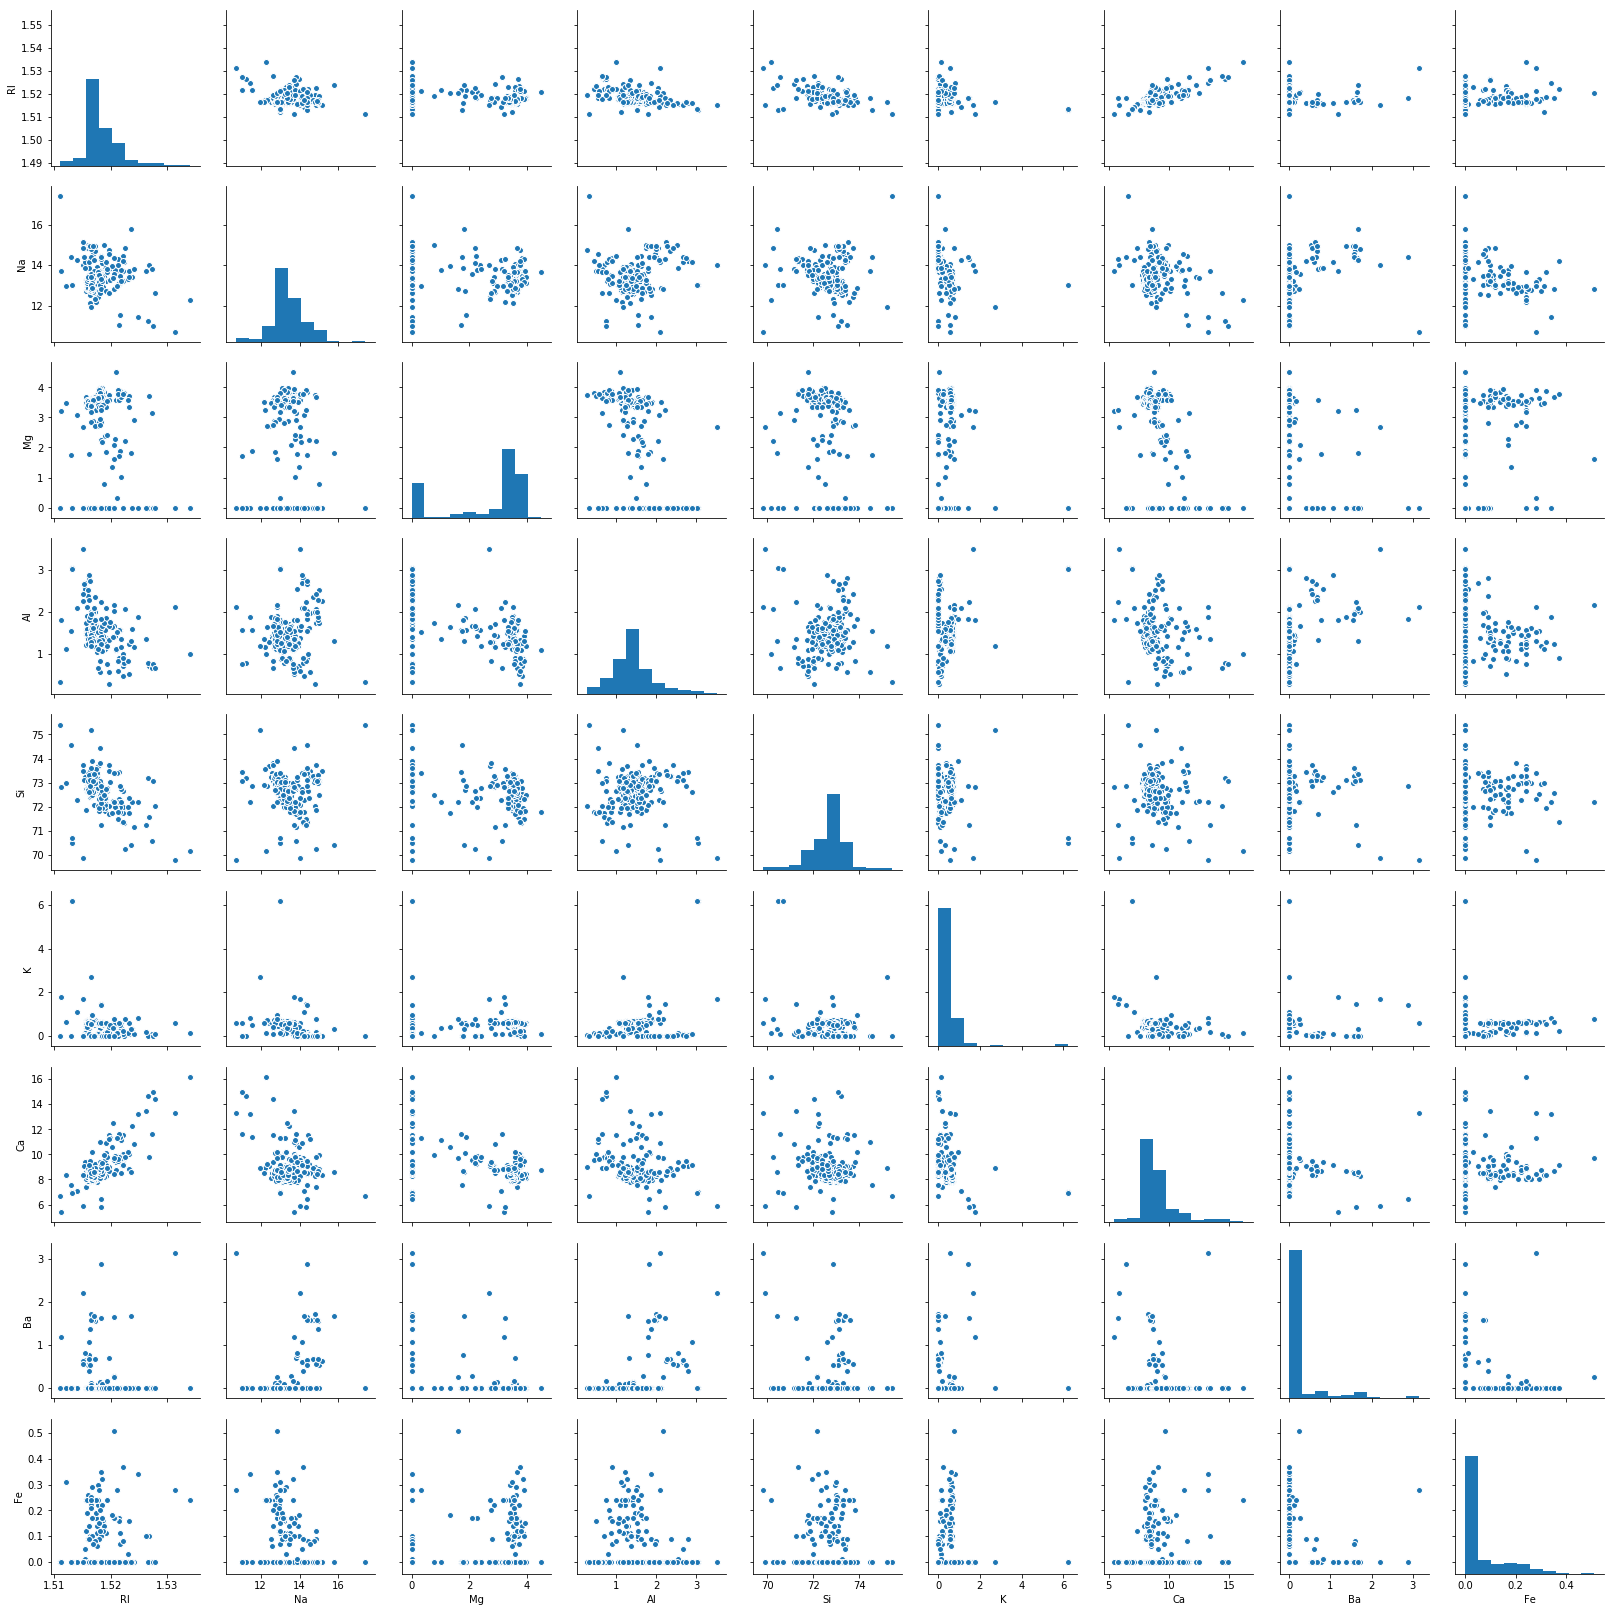

In [57]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

Let's examine a heatmap of the correlations

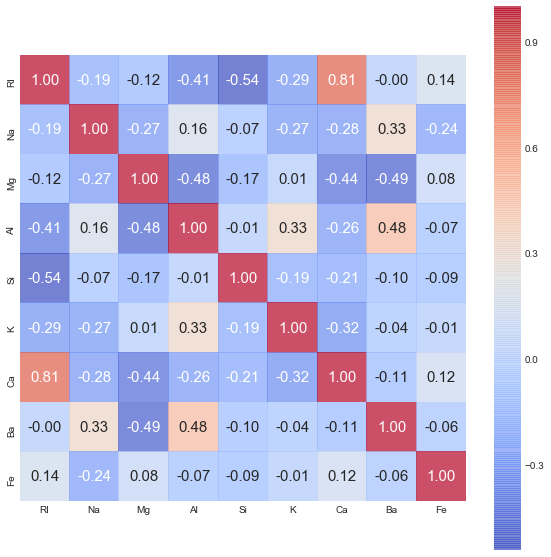

In [94]:
corr = df[features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

There seems to be a strong positive correlation between RI and Ca. This could be a hint to perform Principal component analysis in order to decorrelate some of the input features.

### Prepare Data

In [41]:
#Identify Missing Value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


### Removing Outliers

In [42]:
# The diamond shaped dots outside the boxplot indicates the outliers 
# There are some extreme cases in K, Ba and Fe. 
# That why it is necessary to rule out the outliers 

glassdata = df.copy(deep=True) # Make a copy of original data, just in case

# Create new dataframe for each type

types = glassdata['Type'].unique()
d = {type: glassdata[glassdata['Type'] == type] for type in types}

d[1]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.00,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.00,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.00,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.00,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,1


In [43]:
# Set the quantile

low = .25
high = .75

bounds = {}
for type in types:
    filt_df = d[type].loc[:, d[type].columns != 'Type'] # Remove 'Type' Column
    quant_df = filt_df.quantile([low, high])
    IQR = quant_df.iloc[1,:]-  quant_df.iloc[0,:]
    quant_df.iloc[0,:] = quant_df.iloc[0,:] - 1.5*IQR
    quant_df.iloc[1,:] = quant_df.iloc[1,:] + 1.5*IQR
    bounds[type] = quant_df
    
bounds[1]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0.25,1.51451,11.775,3.21375,0.79,70.67375,-0.385,7.49625,0.0,-0.165
0.75,1.52259,14.575,3.92375,1.65,74.42375,1.175,9.98625,0.0,0.275


In [93]:
# Define our new dataset by removing the outliers 

filt_df = d[1].loc[:, d[1].columns != 'Type'] # Remove 'Type' Column
filt_df = filt_df.apply(lambda x: x[(x>bounds[1].loc[low,x.name]) & (x < bounds[1].loc[high,x.name])], axis=0)
filt_df = pd.concat([filt_df,d[1].loc[:,'Type']], axis=1)

filt_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,NaN,1.10,71.78,0.06,8.75,NaN,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,NaN,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,NaN,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,NaN,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,NaN,0.0,1


In [92]:
# Let's remove the outliers from the dataset 
df_new = {}

for type in types:
    filt_df = d[type].loc[:, d[type].columns != 'Type'] # Remove 'Type' Column
    filt_df = filt_df.apply(lambda x: x[(x>bounds[type].loc[low,x.name]) & (x < bounds[type].loc[high,x.name])], axis=0)
    df_new[type] = pd.concat([filt_df,d[type].loc[:,'Type']], axis=1)


glassdata_new = result = pd.concat(df_new)
glassdata_new.head()

RI     Na    Mg    Al     Si     K    Ca  Ba   Fe  Type
1 0  1.52101  13.64   NaN  1.10  71.78  0.06  8.75 NaN  0.0     1
  1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83 NaN  0.0     1
  2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78 NaN  0.0     1
  3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22 NaN  0.0     1
  4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07 NaN  0.0     1

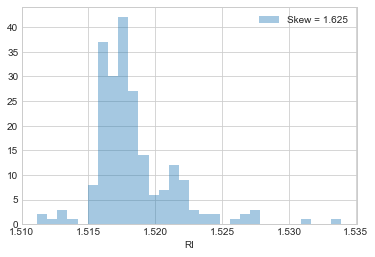

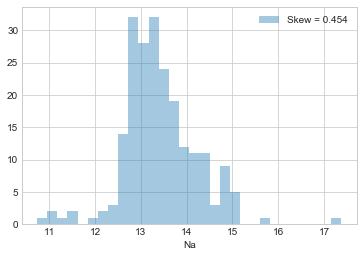

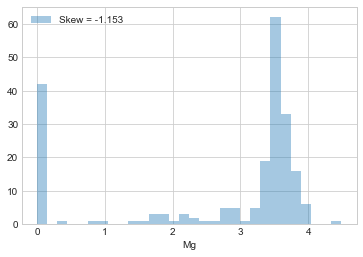

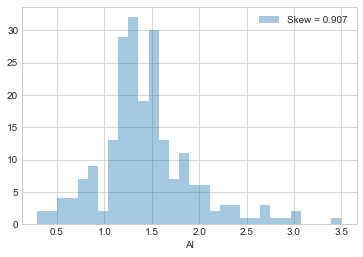

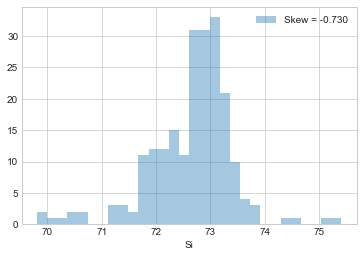

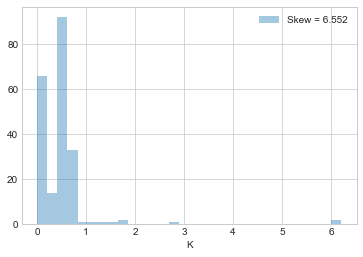

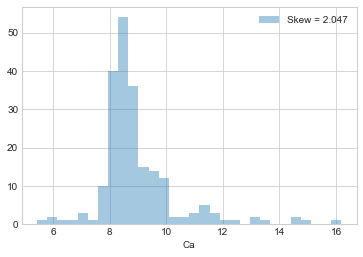

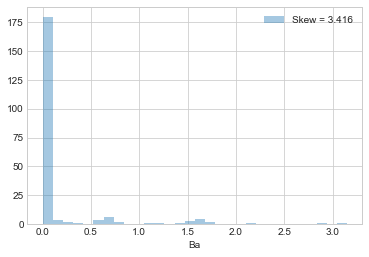

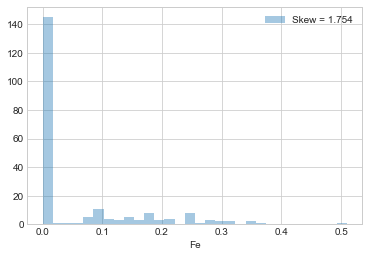

In [91]:
for feat in features:
    skew = glassdata[feat].skew()
    sns.distplot(glassdata[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [52]:
glassdata['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

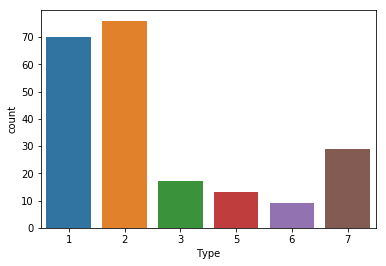

In [53]:
sns.countplot(df['Type'])
plt.show()

## Split-out validation dataset

In [59]:
# Define X as features and y as lablels
X = df[features] 
y = df['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

### Data Transformation

In [78]:
#Feature Scaling

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Evaluate Algorithms

#### Compare Algorithms

SVC: 70.151316 (+/- 8.404443) performed in 44.523089 seconds
KNN: 66.875000 (+/- 8.125639) performed in 6.193513 seconds
RF: 77.767544 (+/- 7.811284) performed in 6.907895 seconds
Ada: 45.752193 (+/- 7.840040) performed in 7.672187 seconds
ET: 77.017544 (+/- 5.505889) performed in 6.224848 seconds
GB: 72.875000 (+/- 11.562507) performed in 6.661071 seconds
LR: 61.706140 (+/- 14.230445) performed in 6.771300 seconds


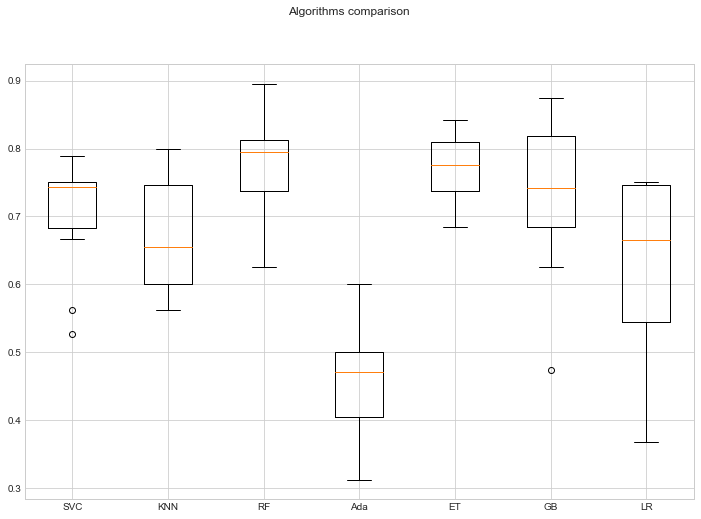

In [88]:
n_components = 5
pipelines = []
n_estimators = 200

#print(df.shape)
pipelines.append( ('SVC',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('SVC', SVC(random_state=seed))]) ) )


pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))


pipelines.append( ('Ada',
                   Pipeline([ 
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                    ('Ada', AdaBoostClassifier(random_state=seed,  n_estimators=n_estimators)) ]) ))

pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('GB',
                   Pipeline([ 
                             ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('GB', GradientBoostingClassifier(random_state=seed)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))

results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [97]:
from sklearn.metrics import precision_recall_fscore_support

### Observation: The best performances are achieved by RF. However, RF also yields a wide distribution. It is worthy to continue our study by tuning RF.

### Logistic Regression performs badly. This might be due to the fact that the data is not normally distributed as these algorithms perform well when data that is normally distributed.